<img src="../images/logo.jpg" style="width:85px;height:85px;float:left" /><h1 style="position:relative;float:left;display:inline">Writing an GAN from scratch</h1>

<a href='https://colab.research.google.com/github/zurutech/gans-from-theory-to-production/blob/master/2.%20GANs%20in%20Tensorflow/2.1.%20Writing%20a%20GAN%20from%20scratch.ipynb'>
    <img align="left" src='https://cdn-images-1.medium.com/max/800/1*ZpNn76K98snC9vDiIJ6Ldw.jpeg'></img>
</a>

In [ ]:
! pip install tf-nightly-gpu-2.0-preview
#! pip install tf-nightly-2.0-preview

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Writing-an-GAN-from-scratch" data-toc-modified-id="Writing-an-GAN-from-scratch-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Writing an GAN from scratch</a></span><ul class="toc-item"><li><span><a href="#What-does-a-GAN-learn?" data-toc-modified-id="What-does-a-GAN-learn?-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>What does a GAN learn?</a></span></li><li><span><a href="#Input-data" data-toc-modified-id="Input-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Input data</a></span></li><li><span><a href="#Generator-and-discriminator-networks:-Keras-functional-API" data-toc-modified-id="Generator-and-discriminator-networks:-Keras-functional-API-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Generator and discriminator networks: Keras functional API</a></span></li><li><span><a href="#Define-input-and-instantiate-networks" data-toc-modified-id="Define-input-and-instantiate-networks-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Define input and instantiate networks</a></span></li><li><span><a href="#The-loss-function-and-the-training-procedure" data-toc-modified-id="The-loss-function-and-the-training-procedure-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>The loss function and the training procedure</a></span><ul class="toc-item"><li><span><a href="#Discriminator-loss-function" data-toc-modified-id="Discriminator-loss-function-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Discriminator loss function</a></span></li><li><span><a href="#Generator-loss-function" data-toc-modified-id="Generator-loss-function-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Generator loss function</a></span></li></ul></li><li><span><a href="#Gradient-ascent" data-toc-modified-id="Gradient-ascent-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Gradient ascent</a></span><ul class="toc-item"><li><span><a href="#Visualize-training" data-toc-modified-id="Visualize-training-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Visualize training</a></span></li><li><span><a href="#Advantages-and-disadvantages" data-toc-modified-id="Advantages-and-disadvantages-1.6.2"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>Advantages and disadvantages</a></span></li></ul></li></ul></li><li><span><a href="#Bonus-exercise:-converting-it-to-a-Conditional-GAN" data-toc-modified-id="Bonus-exercise:-converting-it-to-a-Conditional-GAN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Bonus exercise: converting it to a Conditional GAN</a></span></li></ul></div>

## Writing an GAN from scratch

Previous to version 2.0, Tensorflow allowed us to only define computational graphs. We could hence describe both the generator $G$ and the discriminator $D$, just like two interacting subgraphs.

Keras changes the way of reasoning, making the model definition more pythonic: before Keras we had to reason thinking about graphs and scopes; using Keras we have to thing about objects and attributes.

In Keras a variable lives inside the model, in pure old tensorflow instead, the variable lives in the global graph.

The Keras way of defining the Models is the new standard.

### What does a GAN learn?

The aim of the GAN we are going to implement is to learn a certain **data distribution** present in the training set.

The following example will guide you trough the required steps to build a GAN from scratch using Tensorflow while giving you an **intuition** of what a GAN learns.

### Input data

In order to give a meaningful example, we're going to generate and visualize the distribution that has to be learn.

$$ \mathcal{N}(\mu = 10, \sigma = 0.1) $$

Our **target** distribution is a Gaussian distribution centered in $10$ a with a standard deviation of $0.1$

We're going to use Tensorflow itself to **sample datapoints** from this distribution in order to build our training set.

In [1]:
# Required inclues to create the GAN and to visualize the data
%matplotlib inline

import os
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython import display
import pylab as pl

Tensorflow 2.0 defauls to eager mode execution, therefore we can just use tensorflow as we are used to use other libraries such as `numpy` to generate a dataset.
We can thus define a function that samples from our target distribution of fixed number of data points (2000).

(0, 60)

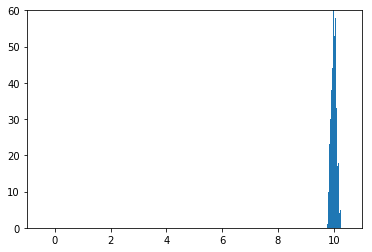

In [2]:
def sample_dataset():
    dataset_shape = (2000, 1)
    return tf.random.normal(mean=10., shape=dataset_shape, stddev=0.1, dtype=tf.float32)

counts, bin, ignored = plt.hist(sample_dataset().numpy(), 100)
axes = plt.gca()
axes.set_xlim([-1,11])
axes.set_ylim([0, 60])

### Generator and discriminator networks: Keras functional API

The **generator** $G$ network architecture is **completely arbitrary**: practice suggests that a simple layer with just 2 fully connected layers and a single linear layer at the output is enough for learning such a simple task.

The **discriminator** $D$ network architecture is **completely arbitrary** too. The only thing that's mandatory is the use of the **linear activation** in the single output neuron.

This is due to the fact that we're going to use a tensorflow built-in loss function to train this classifier and this function requires an "logits" as input vector, aka a linear output.

We use a standard (and powerful) way of defining Keras models: the functional API.
In this formulation we can just use the keras layers as functions: they accept an input and produce an output - easy.

For a simple model definition like that a functional approach is not strictly required since a simplier interface like `Sequential` could be enough; however, we described the model using the functional approach because we found it more powerful and architecture-change ready.

In [3]:
def generator(input_shape):
    """Defines the generator keras.Model.
    Args:
        input_shape: the desired input shape (e.g.: (latent_space_size))
    Returns:
        G: The generator model
    """
    inputs = tf.keras.layers.Input(input_shape)
    net = tf.keras.layers.Dense(units=64, activation=tf.nn.elu, name="fc1")(inputs)
    net = tf.keras.layers.Dense(units=64, activation=tf.nn.elu, name="fc2")(net)
    net = tf.keras.layers.Dense(units=1, name="G")(net)
    G = tf.keras.Model(inputs=inputs, outputs=net)
    return G

def disciminator(input_shape):
    """Defines the discriminator keras.Model.
    Args:
        input_shape: the desired input shape (e.g.: (the generator output shape))
    Returns:
        D: the discriminator model
    """
    inputs = tf.keras.layers.Input(input_shape)
    net = tf.keras.layers.Dense(units=32, activation=tf.nn.elu, name="fc1")(inputs)
    net = tf.keras.layers.Dense(units=1, name="D")(net)
    D = tf.keras.Model(inputs=inputs, outputs=net)
    return D

### Define input and instantiate networks

The two functions just defined allow us to instantiate the models.

In [4]:
# Define the real input shape, a batch of values sampled from the real data
input_shape = (1,)

# Define the discriminator model
D = disciminator(input_shape)

# Arbitrary set the shape of the noise prior
latent_space_shape = (100,)
# Define the input noise shape and define the generator
G = generator(latent_space_shape)

### The loss function and the training procedure

As the theory describes, the training procedure is the **alternating** execution of training steps. In the next few lines we're going to implement the **non saturating** version of the value function.

As described above, the output layers of the 2 models have **linear output** because we're going to use the `tf.keras.losses.BinaryCrossentropy(from_logits=True)` that accepts logits as input.

In practice, the `tf.keras.losses.BinaryCrossentropy(from_logits=True)` computes the binary cross entropy between two distributions:

1. the learned distribution, that assigns a probability to a certain class, that's why the function applies the **sigmoid**  $\sigma$ function to the output neuron, in order to consider the output a probability (range [0-1])
2. the conditional empirical distribution over class labels (a probability distribution where the probability of the current observed positive sample is 1 and is 0 for any other class)

$$ \mathcal{L}_{BCE} = y \log(\hat{y}) - (1 - y)\log(1 - \hat{y}) $$

#### Discriminator loss function

Given the labels for the positive class and the nevative class to be 1 and 0 respectively, the loss becomes the sum of 2 BCE:

$$ \frac{1}{m} \sum_{i=1}^{m}- \log \sigma(D(x^{(i)})) + \frac{1}{m} \sum_{i=1}^{m} - \log(1 - \sigma(D(G(z^{(i)})) $$

The loss function is the binary cross entropy between the class of the real samples (label 1) and the class of the generated samples (label 0).

In [5]:
def d_loss(real_output, generated_output):
    """The disciminator loss function."""
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(generated_output), generated_output)

#### Generator loss function
$$ -\frac{1}{m} \sum_{i=1}^{m} \sigma(\log(D(G(z)))) $$

The loss function is just the binary cross entropy between the log probability of the generated images and the distribution of the real images (label 1)

In [6]:
def g_loss(generated_output):
    """The Generator loss function."""
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return bce(tf.ones_like(generated_output), generated_output)

### Gradient ascent

In order to train 2 different networks one next to the other, we can just exploit the fact that we can specify a the list of variables to train to an optimizer and it will take care of updating only that variables.
Using Keras this is for free, since every single Model brings its own set of `trainable_variables`.

The training process is **exactly** the one described in the GAN paper thanks to the eager mode.

The `@tf.function` annotation allow to convert the most computational-intensive part of the training into its graph representation and accelerate, thus, the training process.

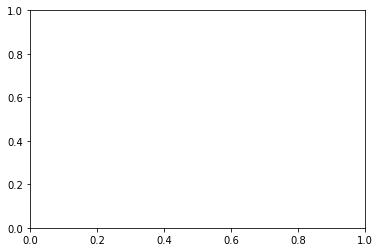

In [7]:
# Let's play the min-max game
if not os.path.exists("./gif/"):
     os.makedirs("./gif/")

def train():
    # Define the optimizers and the train operations
    optimizer = tf.keras.optimizers.Adam(1e-5)
    
    @tf.function
    def train_step():
        with tf.GradientTape(persistent=True) as tape:
            real_data = sample_dataset()
            noise_vector = tf.random.normal(mean=0, stddev=1, shape=(real_data.shape[0], latent_space_shape[0]))
            # Sample from the Generator
            fake_data = G(noise_vector)
            # Compute the D loss
            d_fake_data = D(fake_data)
            d_real_data = D(real_data)
            d_loss_value = d_loss(generated_output=d_fake_data, real_output=d_real_data)
            # Compute the G loss
            g_loss_value = g_loss(generated_output=d_fake_data)
        # Now that we comptuted the losses we can compute the gradient (using the tape)
        # and optimize the networks
        d_gradients = tape.gradient(d_loss_value, D.trainable_variables)
        g_gradients = tape.gradient(g_loss_value, G.trainable_variables)
        del tape
        
        optimizer.apply_gradients(zip(d_gradients, D.trainable_variables))
        optimizer.apply_gradients(zip(g_gradients, G.trainable_variables))
        return real_data, fake_data, g_loss_value, d_loss_value
    
    fig, ax = plt.subplots()
    for step in range(40000):
        real_data, fake_data,g_loss_value, d_loss_value = train_step()
        if step % 200 == 0:
            print("G loss: ", g_loss_value.numpy(), " D loss: ", d_loss_value.numpy(), " step: ", step)

            # Sample 5000 values from the Generator and draw the histogram
            ax.hist(fake_data.numpy(), 100)
            ax.hist(real_data.numpy(), 100)
            # these are matplotlib.patch.Patch properties
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

            # place a text box in upper left in axes coords
            textstr = f"step={step}"
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                    verticalalignment='top', bbox=props)

            axes = plt.gca()
            axes.set_xlim([-1,11])
            axes.set_ylim([0, 60])
            display.display(pl.gcf())
            display.clear_output(wait=True)
            plt.savefig("./gif/{}.png".format(step))
            plt.gca().clear()
            
train()

#### Visualize training

Every 200 steps of train we generated and saved the histogram of 2000 values sampled from the target distribution and 2000 values sampled from the generator output.


In order to generate a nice animation of the learning process we can just use the `imagemagick` tool to merge all the images into a pretty cool gif of the learning process.
This gif shows you how the learning process learned to shift the initial random distribution to the correct value of $10$ and to adjust the variance in order to be close to the one of **target distribution**.

In [8]:
! convert -delay 20 -loop 0 $(ls gif/*.png | sort -V) gif/learning_gaussian.gif

![learn](gif/learning_gaussian.gif)

#### Advantages and disadvantages

Writing a GAN from scratch using the new Tensorflow 2.0 API is extremely helpful for learning how to correctly define our own training loop, how the write a GAN, and understand the theory required to make the network learn.

However, this example could become way more complex if we add:

- The dataset generation: the targte distribution is not generated but should be learned from a real dataset.
- The logging: use `tf.summary.*` methods to log metrics.
- The usage of `tf.Saver` to log the summaries and to save the trained model.
- The data visualization in tensorbard.
- The export of the model with the correct input definition in order to be ready for serving.
- ...

In order to speed-up the development time, the tensorflow devs introduced the `tf.estimator`<sup>[1](#1)</sup> and `tf.data`<sup>[2](#1)</sup> API: an high level API that greatly simplifies the model training.
Estimators encapsulate the following actions:

- training
- evaluation
- prediction
- export for serving

While the `tf.data` API made the dataset generation extremely easy.
Moreover, in tensorflow 2.0 a new (and huge!) set of performance-optimized and well-designed dataset has been added: tensorflow-dataset (`tfds`).

In the next chapter, we'll see how to use the `tf.estimator` and `tfds` (that uses `tf.data`) to train a GAN.

We'll start with the definition of the data and of the discriminator.

## Bonus exercise: converting it to a Conditional GAN

Extending this simple GAN making it conditional can be a good test bench to check your understanding of the GAN theory explained in the first section.

Remeber that both $G$ and $D$ needs to be conditioned and that the train process is just the same game, played for every different condition.

Copy this notebook and try to condition this GAN in order to learn 2 different normal distributions.

- Condition `0`: generates $\mathcal{N}(10, 0.1)$
- Condition `1`: generates $\mathcal{N}(20, 0.2)$

A solution to this exersice can be found in the notebook: [BONUS - Conditional GAN from scratch](BONUS - Conditional GAN from scratch.ipynb).

---
<a id="1">[1]</a>: https://www.tensorflow.org/guide/estimators

<a id="2">[2]</a>: https://www.tensorflow.org/guide/datasets